# Mathematical Underpinnings - Lab 1

## Task 1
### a) Generative approach 

We know $\pi = P(Y=1)$ and the distributions $f(x|Y=1)$ and $f(x|Y=-1)$.

#### First bullet point

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
np.random.seed(0)

In [3]:
# sampling from multivariate normal distribution and from Bernoulli

# x = np.random.multivariate_normal(np.array([0,0]), np.eye(2), 5)
# y = np.random.binomial(1, 0.5, 5)
# x, y

In [4]:
m1 = np.array([1,1])
m2 = np.array([0,0])

sigma = np.array([[1, -0.5],[-0.5, 1]])

In [5]:
# sampling
Y_generative = np.array([1 for _ in range(500)] + [0 for _ in range(500)])
X_generative = np.concatenate([
    np.random.multivariate_normal(m1, sigma, 500), 
    np.random.multivariate_normal(m2, sigma, 500)
])

Does the distribution of $P(Y=1|X=x)=p(y=1|x)$ correspond to a logistic model?

A hint: Use Bayes theorem to compute $p(y=1|x)$. Is it possible to represent $p(y=1|x)$ as $\frac{e^{\beta_0 + \beta x}}{1 + e^{\beta_0 + \beta x}}$?


**Answer:** Yes.

$$p(x|y=1) = (2\pi)^{-d/2} \textrm{det}(\Sigma)^{-d/2} \exp(-(x-m_1)'\Sigma^{-1}(x-m_1)/2) = C\exp(-(x-m_1)'\Sigma^{-1}(x-m_1)/2)$$

$$p(x|y=-1) = (2\pi)^{-d/2} \textrm{det}(\Sigma)^{-d/2} \exp(-(x-m_2)'\Sigma^{-1}(x-m_2)/2) = C\exp(-(x-m_2)'\Sigma^{-1}(x-m_2)/2).$$

$$p(y=1|x) = \frac{\pi p(x|y=1)}{p(x)} = \frac{\pi p(x|y=1)}{\pi p(x|y=1) + (1-\pi) p(x|y=-1)} = \frac{\pi p(x|y=1)/(1-\pi) p(x|y=-1)}{\pi p(x|y=1)/(1-\pi) p(x|y=-1) + 1}.$$

$$\pi p(x|y=1)/(1-\pi) p(x|y=-1) = \exp(x'\Sigma^{-1}m_1 + \log(\pi/(1-\pi)) + m_2'\Sigma^{-1}m_2/2 -  m_1'\Sigma^{-1}m_1/2),$$

$$\beta_0=\log(\pi/(1-\pi)) + m_2'\Sigma^{-1}m_2/2 -  m_1'\Sigma^{-1}m_1/2,$$
$$\beta = \Sigma^{-1}(m_1 - m_2).$$

#### Second bullet point

Find the formulas for the parameters of the logistic model (the coefficients and the intercept).

A hint: Use the representation of $p(y=1|x)$ from the first bullet point and solve for $\beta_0$ and $\beta$.

**Answer:** As above.

In [6]:
# computing beta_0 and beta using the formulas

In [7]:
pi1 = 0.5
sigma_inv = np.linalg.inv(sigma)

beta_0 = np.log(pi1) - np.log(1 - pi1) + m2.dot(sigma_inv.dot(m2))/2 - m1.dot(sigma_inv.dot(m1))/2
beta = np.linalg.inv(sigma) @ (m1 - m2)

print(f"beta_0: {beta_0}\nbeta: {beta}")

beta_0: -2.0
beta: [2. 2.]


In [8]:
# a logistic model
mod_a = LogisticRegression(penalty=None)
mod_a.fit(X_generative, Y_generative)

print(f"beta_0: {mod_a.intercept_[0]}\nbeta: {list(mod_a.coef_[0])}")

beta_0: -1.95112346028384
beta: [1.9825541553155974, 1.9768925075259847]


### b) Discriminative approach

We know $f(x)$ and $P(Y=1|X=x)$.

#### First bullet point

In [9]:
m_list = [m1, m2]
sigma_list = [sigma, sigma]
p_list = [0.5, 0.5]

def generate_sample_from_mixture(m_list, sigma_list, p_list, n):
    cumulated_p_list = np.cumsum(p_list)
    
    X = np.zeros((n, len(m_list)))
    for i in range(n):
        # sample from uniform distribution
        u = np.random.uniform(0, 1)
        # find the largest index of the cumulated_p_list that is smaller than u
        j = np.argmax(cumulated_p_list > u)
        
        # sample from the multivariate normal distribution with the mean m_list[j] and the covariance matrix sigma_list[j]
        X[i] = np.random.multivariate_normal(m_list[j], sigma_list[j])
    return X

In [10]:
# sampling
X_discriminative = generate_sample_from_mixture(m_list, sigma_list, p_list, 1000)
Y_discriminative = np.random.binomial(
    1, 
    1/(1 + np.exp(2 - 2 * X_discriminative[:,0] - 2 * X_discriminative[:,1])), 
    1000
)

In [11]:
mod_b = LogisticRegression(penalty=None)
mod_b.fit(X_discriminative, Y_discriminative)

print(f"beta_0: {mod_b.intercept_[0]}\nbeta: {list(mod_b.coef_[0])}")

beta_0: -2.150754838461052
beta: [2.0208098913679984, 2.114000280244077]


#### Second bullet point

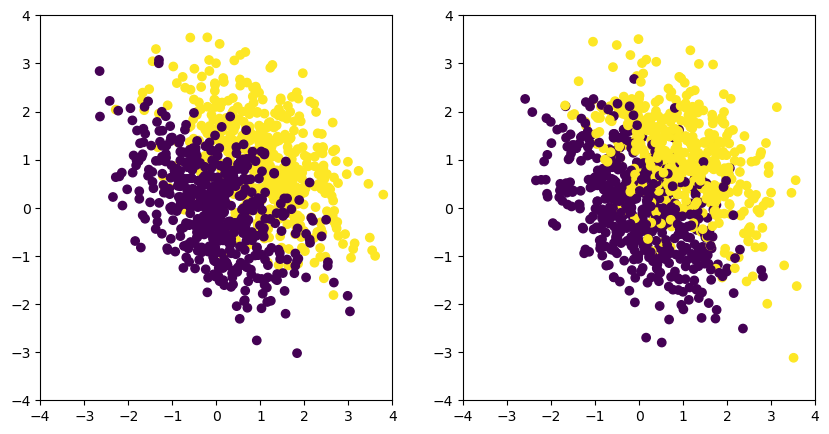

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x=X_generative[:, 0], y=X_generative[:, 1], c=Y_generative)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.subplot(1, 2, 2)
plt.scatter(x=X_discriminative[:, 0], y=X_discriminative[:, 1] , c=Y_discriminative)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.show()

What distinguishes the generative approach from the discriminative approach?

**Answer:** We have the same joint distributions of $p(x,y)$ (which is visible in scatterplots), but the two approaches differ from a simulation and modeling point of view. 

In generative approach we cannot estimate $\pi$. Moreover, in generative approach $\pi$ and $\beta_0$ are entangled as indicated by the formulas in a). 

### c)

To sample from $f_{X|Y=-1}$, first, we will give an answer to Q1.

Q1. A hint: use Bayes theorem for $p(x|y=-1)$ and use law of total probability for $p(x)$.

**Answer:** We can use a formula, we obtained in a)

$$p(y=1|x) = \frac{\pi p(x|y=1)}{\pi p(x|y=1) + (1-\pi) p(x|y=-1)}.$$

Now we transform to get a formula for $p(x|y=-1)$:

    $$ p(x|y=-1) = \frac{\pi p(x|y=1) (1- p(y=1|x))}{p(y=1|x)(1-\pi)}.$$

We plug in $p(x|y=1) = \exp(-x)$ as $X$ given $Y=1$ follows an exponential distribution with $\lambda=1$, $p(y=1|x) = 1/(1+\exp(-\beta_0-\beta_1 x))$ (a logistic model assumption) and $p(y=-1|x) = 1/(1+\exp(\beta_0+\beta_1 x))$, thus

$$ p(x|y=-1) = \frac{\pi \exp(-x)}{\exp(\beta_0+\beta_1 x)(1-\pi)} = C_{\beta_0, \pi} \exp(-(\beta_1+1)x).$$

$X$ given $Y=-1$ also follows exponential distribution with $\lambda=\beta_1+1$.

Q2, Q3, Q4. A hint: what is the distribution of $f_{X|Y=-1}$? What ia a norming constant?

In the above equations, $$C_{\beta_0, \pi} = \frac{\pi}{\exp(\beta_0)(1-\pi)}$$.

We also know that $$1 = \int_{0}^{\infty} p(x|y=-1) dx = C_{\beta_0, \pi} \int_{0}^{\infty} \exp{(-(\beta_{1}+1))} dx = C_{\beta_0, \pi} * \frac{1}{\beta_{1}+1}$$

$$C_{\beta_0, \pi} = \frac{\pi}{\exp(\beta_0)(1-\pi)} = \beta_{1}+1$$

**Answer Q2**: If $\pi$ is fixed, we have freedom in choosing the intercept as long as we also adjust $\beta_{1}$ parameter. If both $\pi$ and $\beta_{1}$ are fixed, we do not have freedom in choosing the intercept.

**Answer Q3**: The value of $\beta_{0}$ depends on the value of $\pi$ and $\beta_{1}$. If $\pi$ is not known, the intercept is not uniquely determined.

**Homework**: If that is doable, given $\beta_1$ and $\pi$ compute $\beta_0$.

$$\beta_{0} = \ln{(\frac{\pi}{(1-\pi)(\beta_{1}+1)})}$$

If $n_{1} = 1000$ and $n_{2} = 2000$, then $\pi = 1/3$. Additionally, $\beta_{1} = 1$.

$$\beta_{0} = \ln{(\frac{1/3}{(1-1/3)(1+1)})} = \ln{(\frac{1}{4})} = -\ln{4} \approx 1.38$$

In [13]:
# sampling
beta1 = 1
n1 = 1000
n2 = 2000
Lambda = 1

x1 = np.random.exponential(1/Lambda, size=n1)
x2 = np.random.exponential(1/(beta1 + 1), size=n2)

X = np.concatenate([x1, x2]).reshape(-1, 1)
y = np.concatenate([np.ones(n1), np.zeros(n2)])

In [14]:
# a model
mod = LogisticRegression(penalty=None)
mod.fit(X, y)
print(f"beta_0: {mod.intercept_[0]}\nbeta: {list(mod.coef_[0])}")

beta_0: -1.3684570793518018
beta: [0.9763315773618286]


In [15]:
# a numeric answer to the question about beta0
pi_c = n1 / (n1 + n2)
-np.log((1 - pi_c)/pi_c * (beta1 + 1))

-1.3862943611198908

## Task 2

### a)

$R(a,a^*) = \mathbb{E} \mathcal{L}(f(X), Y) = \mathbb{E}(aX - Y)^2 = ...$,

In our task we know $a^* = 1$.

In [268]:
# def population_risk(a, sigma_eps):
#     return ...

### b)

In [269]:
# sampling

Empirical risk: $\frac{1}{n} \sum_{i=1}^n (ax_i - y_i)^2$

In [270]:
# def empirical_risk(a, x, y):
#     return ...

### c)

In [37]:
# code, plot

### d)

Excess risk: $$E(\hat a, a^*) =R(\hat a, a^*) - \textrm{inf}_{a \in A_0} R(a, a^*)$$

In [38]:
# excess risk
# ...

In [39]:
# simulations with fixed sample size

In [276]:
# simulations for various sample sizes

In [40]:
# a nice plot visualising the results (how the unconditional excess risk changes with a sample size)